In [1]:
import pandas as pd
import numpy as np
import scipy
from tableone import TableOne
%load_ext autoreload
%autoreload 2

# Load Epitope Database

In [2]:
path_cohort = '~/Global Data/KaplanMeier/DESAsurvival_original.csv'
df_cohort = pd.read_csv(path_cohort, sep=';', decimal=',')

# path_cohort = '~/UMCUtrecht/ProcessedData/procare_1_cohort/procare_1_cohort.csv'
# path_cohort = '~/UMCUtrecht/ProcessedData/procare_1_cohort/procare_1_cohort.xlsx'
path_antibody = '~/Global Data/20211104_mismatch_ep_db.pickle' # Danial\Global Data\
df_abs = pd.read_pickle(path_antibody)
# There is also another DESA column in the df_cohort.
# df_cohort = pd.read_excel(path_cohort, skiprows=1)

df = df_abs.merge(df_cohort, on='TransplantID')

##  Table 1

### Revision - Short communication

In [3]:
df['DESA_Status'].value_counts()

No MFI         2840
No DESA         853
No HLAE-Abs     558
DESA            439
Name: DESA_Status, dtype: int64

In [4]:
# selected variables
cols = [
    'DESA_Status', 
    'RecipientAge_NOTR', 'RecipientSex_NOTR', 'DialysisYears',
    'DonorAge_NOTR', 'DonorSex_NOTR', 
    # 'TypeOfDonor_NOTR',
    'TypeCadaveric_NOTR', 
    'CIPHour_DBD', 'CIPHour_DCD',
    'CIPHour',
    'Retransplant', 
    'CurrentPRA_NOTR',
    'HighPRA_NOTR',
    'ALG_ATG_OKT3_AntiPanTMoAb',
    'IL2rMoAb_T0',
    'NumMismatch_ABDR_broad',
    'Steroids_T0', 'MMF_T0', 'Aza_T0', 'Sirolimus_T0', 'Cyclosporin_T0', 'Tacrolimus_T0', 'Unknown_T0', 'Others_T0',
    'DialysisYN',
    
]
df_t1 = df[cols]
#df_t1['DESA_Status'] = df_t1['DESA_Status'].apply(lambda x:'DESA' if x == 'DESA' else 'No DESA') # submitted
df_t1['DESA_Status'] = df_t1['DESA_Status'].apply(lambda x:'No HLAE-Abs' if x == 'No MFI' else x) # revision; distinguish no DESA with HLA-abs from no HLA-abs
df_t1['TypeCadaveric_NOTR'].fillna('Living', inplace=True)

df_t1['CIPDeceadDonor'] = (df_t1['CIPHour_DBD'] + df_t1['CIPHour_DCD']).replace(0, np.nan)
for g, v in df.groupby('TypeOfDonor_NOTR')['CIPHour']:
    if g == 'Living':
        df_t1['CIPLivingDonor'] = v
df_t1.drop(['CIPHour_DBD', 'CIPHour_DCD', 'CIPHour'], axis =1, inplace=True)
df_t1['MMF/azathioprine'] = df[['MMF_T0', 'Aza_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1['Cyclosporin/Tacrolimus'] = df[['Cyclosporin_T0', 'Tacrolimus_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1.drop(['Cyclosporin_T0', 'Tacrolimus_T0', 'MMF_T0', 'Aza_T0'], axis =1, inplace=True)

/tmp/ipykernel_32100/4273088080.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['DESA_Status'] = df_t1['DESA_Status'].apply(lambda x:'No HLAE-Abs' if x == 'No MFI' else x) # revision; distinguish no DESA with HLA-abs from no HLA-abs
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_32100/4273088080.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [5]:
df_t1['DESA_Status'].value_counts()

No HLAE-Abs    3398
No DESA         853
DESA            439
Name: DESA_Status, dtype: int64

In [6]:
#df_t1.to_csv('/Users/Danial/UMCUtrecht/ProcessedData/tableone.csv')

In [7]:
'MMF/azathioprine' in df_t1.columns
'Cyclosporin/Tacrolimus' in df_t1.columns

True

In [8]:
# columns containing categorical variables
categorical = ['RecipientSex_NOTR', 'DonorSex_NOTR', 
'IL2rMoAb_T0', 'ALG_ATG_OKT3_AntiPanTMoAb',
'Retransplant', 'TypeCadaveric_NOTR', 'DialysisYN',
'Steroids_T0', 'Sirolimus_T0', 'MMF/azathioprine', 'Cyclosporin/Tacrolimus', 'Unknown_T0', 'Others_T0',
]

# optionally, a categorical variable for stratification
groupby = ['DESA_Status']

# rename the death column
labels={
    'DonorAge_NOTR': 'Donor Age',
    'DonorSex_NOTR': 'Donor Sex',
    'RecipientAge_NOTR': 'Recipiet Age',
    'RecipientSex_NOTR': 'Recipiet Sex',
    'DialysisYears': 'Time on dialysis, y',
    'TypeCadaveric_NOTR': 'Type of Donor',
    'CIPDeceadDonor': ' Cold Ischemia Time Deceased Donors', 
    'CIPLivingDonor': ' Cold Ischemia Time Living Donors', 
    'CurrentPRA_NOTR': 'PRA at time of transplant, %',
    'HighPRA_NOTR': 'Highest PRA, %',
    'NumMismatch_ABDR_broad': 'HLA-A/B/DR broad mismatches, mean ± SD', 
    'Dialysis': 'DialysisYN',
}

continuous = {
    'DonorAge_NOTR', 'RecipientAge_NOTR', 'CIPDeceadDonor', 'DialysisYears',
    'CIPLivingDonor', 'CurrentPRA_NOTR', 'HighPRA_NOTR', 'NumMismatch_ABDR_broad',
    }
# htest = {var:scipy.stats.mannwhitneyu for var in continuous}

htest = {'RecipientAge_NOTR': scipy.stats.mannwhitneyu}

# link to documentation https://github.com/tompollard/tableone/blob/master/tableone/tableone.py

table1 = TableOne(
    df_t1, 
    groupby=groupby,
    missing=True,
    categorical=categorical,
    pval=True,
    rename=labels,
    htest_name=True,
    # htest=htest,
)
table1

Grouped by DESA_Status                                                                                                       
                                                                                  Missing      Overall         DESA      No DESA  No HLAE-Abs P-Value                                       Test
n                                                                                                 4690          439          853         3398                                                   
Recipiet Age, mean (SD)                                                                 0  45.4 (14.4)  44.6 (13.7)  45.1 (13.7)  45.6 (14.6)   0.270                              One-way ANOVA
Recipiet Sex, n (%)                               Female                                0  1879 (40.1)   267 (60.8)   497 (58.3)  1115 (32.8)  <0.001                                Chi-squared
                                                  Male                                     2811 (59.9)   172 (39.2)   356 (41.7)  2283 (67.2)                                                   
Time on dialysis, y, mean (SD)                                                          0    2.8 (2.5)    3.3 (3.0)    3.4 (3.0)    2.5 (2.2)  <0.001                              One-way ANOVA
Donor Age, mean (SD)                                                                    0  44.3 (15.0)  45.1 (15.3)  43.5 (14.6)  44.4 (15.1)   0.163                              One-way ANOVA
Donor Sex, n (%)                                  Female                                0  2366 (50.4)   193 (44.0)   412 (48.3)  1761 (51.8)   0.003                                Chi-squared
                                                  Male                                     2324 (49.6)   246 (56.0)   441 (51.7)  1637 (48.2)                                                   
Type of Donor, n (%)                              Heartbeating                          0  2427 (51.7)   248 (56.5)   551 (64.6)  1628 (47.9)  <0.001                                Chi-squared
                                                  Living                                   1455 (31.0)   124 (28.2)   184 (21.6)  1147 (33.8)                                                   
                                                  Non-heartbeating                          808 (17.2)    67 (15.3)   118 (13.8)   623 (18.3)                                                   
Retransplant, n (%)                               No                                    0  3970 (84.6)   239 (54.4)   486 (57.0)  3245 (95.5)  <0.001                                Chi-squared
                                                  Yes                                       720 (15.4)   200 (45.6)   367 (43.0)    153 (4.5)                                                   
PRA at time of transplant, %, mean (SD)                                                41   6.0 (17.5)  25.6 (31.7)  16.2 (26.3)    0.9 (4.3)  <0.001                              One-way ANOVA
Highest PRA, %, mean (SD)                                                              41  13.9 (25.9)  43.8 (36.8)  36.1 (34.9)   4.4 (10.7)  <0.001                              One-way ANOVA
ALG_ATG_OKT3_AntiPanTMoAb, n (%)                  No                                    0  4506 (96.1)   409 (93.2)   799 (93.7)  3298 (97.1)  <0.001                                Chi-squared
                                                  Yes                                        184 (3.9)     30 (6.8)     54 (6.3)    100 (2.9)                                                   
IL2rMoAb_T0, n (%)                                No                                    0  3675 (78.4)   353 (80.4)   692 (81.1)  2630 (77.4)   0.034                                Chi-squared
                                                  Yes                                      1015 (21.6)    86 (19.6)   161 (18.9)   768 (22.6)                                                   
HLA-A/B/DR bro

### Revision - DESA paper

In [9]:
df['NumMismatch_ABDRDQ_broad'] = df['NumMismatch_ABDR_broad'] + df['mmDQ_broadLevel']

In [10]:
# selected variables
cols = [
    'DESA_Status', 
    'RecipientAge_NOTR', 'RecipientSex_NOTR', 'DialysisYears',
    'DonorAge_NOTR', 'DonorSex_NOTR', 
    # 'TypeOfDonor_NOTR',
    'TypeCadaveric_NOTR', 
    'CIPHour_DBD', 'CIPHour_DCD',
    'CIPHour',
    'Retransplant', 
    'CurrentPRA_NOTR',
    'HighPRA_NOTR',
    'ALG_ATG_OKT3_AntiPanTMoAb',
    'IL2rMoAb_T0',
    'NumMismatch_ABDR_broad',
    'Steroids_T0', 'MMF_T0', 'Aza_T0', 'Sirolimus_T0', 'Cyclosporin_T0', 'Tacrolimus_T0', 'Unknown_T0', 'Others_T0',
    'DialysisYN',
    
]
df_t1 = df[cols]
df_t1['DESA_Status'] = df_t1['DESA_Status'].apply(lambda x:'DESA' if x == 'DESA' else 'No DESA') # submitted
df_t1['TypeCadaveric_NOTR'].fillna('Living', inplace=True)

df_t1['CIPDeceadDonor'] = (df_t1['CIPHour_DBD'] + df_t1['CIPHour_DCD']).replace(0, np.nan)
for g, v in df.groupby('TypeOfDonor_NOTR')['CIPHour']:
    if g == 'Living':
        df_t1['CIPLivingDonor'] = v
df_t1.drop(['CIPHour_DBD', 'CIPHour_DCD', 'CIPHour'], axis =1, inplace=True)
df_t1['MMF/azathioprine'] = df[['MMF_T0', 'Aza_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1['Cyclosporin/Tacrolimus'] = df[['Cyclosporin_T0', 'Tacrolimus_T0']].apply(lambda x: 'Yes'  if ((x[0] == 'Yes') | (x[1] == 'Yes')) else 'No', axis=1)
df_t1.drop(['Cyclosporin_T0', 'Tacrolimus_T0', 'MMF_T0', 'Aza_T0'], axis =1, inplace=True)

/tmp/ipykernel_32100/1342074987.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1['DESA_Status'] = df_t1['DESA_Status'].apply(lambda x:'DESA' if x == 'DESA' else 'No DESA') # submitted
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/tmp/ipykernel_32100/1342074987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [11]:
df_t1['DESA_Status'].value_counts()

No DESA    4251
DESA        439
Name: DESA_Status, dtype: int64

In [12]:
# columns containing categorical variables
categorical = ['RecipientSex_NOTR', 'DonorSex_NOTR', 
'IL2rMoAb_T0', 'ALG_ATG_OKT3_AntiPanTMoAb',
'Retransplant', 'TypeCadaveric_NOTR', 'DialysisYN',
'Steroids_T0', 'Sirolimus_T0', 'MMF/azathioprine', 'Cyclosporin/Tacrolimus', 'Unknown_T0', 'Others_T0',
]

# optionally, a categorical variable for stratification
groupby = ['DESA_Status']

# rename the death column
labels={
    'DonorAge_NOTR': 'Donor Age',
    'DonorSex_NOTR': 'Donor Sex',
    'RecipientAge_NOTR': 'Recipiet Age',
    'RecipientSex_NOTR': 'Recipiet Sex',
    'DialysisYears': 'Time on dialysis, y',
    'TypeCadaveric_NOTR': 'Type of Donor',
    'CIPDeceadDonor': ' Cold Ischemia Time Deceased Donors', 
    'CIPLivingDonor': ' Cold Ischemia Time Living Donors', 
    'CurrentPRA_NOTR': 'PRA at time of transplant, %',
    'HighPRA_NOTR': 'Highest PRA, %',
    'NumMismatch_ABDR_broad': 'HLA-A/B/DR broad mismatches, mean ± SD', 
    'Dialysis': 'DialysisYN',
}

continuous = {
    'DonorAge_NOTR', 'RecipientAge_NOTR', 'CIPDeceadDonor', 'DialysisYears',
    'CIPLivingDonor', 'CurrentPRA_NOTR', 'HighPRA_NOTR', 'NumMismatch_ABDR_broad',
    }
# htest = {var:scipy.stats.mannwhitneyu for var in continuous}

htest = {'RecipientAge_NOTR': scipy.stats.mannwhitneyu}

# link to documentation https://github.com/tompollard/tableone/blob/master/tableone/tableone.py

table1 = TableOne(
    df_t1, 
    groupby=groupby,
    missing=True,
    categorical=categorical,
    pval=True,
    rename=labels,
    htest_name=True,
    # htest=htest,
)
table1

Grouped by DESA_Status                                                                                          
                                                                                  Missing      Overall         DESA      No DESA P-Value                                       Test
n                                                                                                 4690          439         4251                                                   
Recipiet Age, mean (SD)                                                                 0  45.4 (14.4)  44.6 (13.7)  45.5 (14.4)   0.168                          Two Sample T-test
Recipiet Sex, n (%)                               Female                                0  1879 (40.1)   267 (60.8)  1612 (37.9)  <0.001                                Chi-squared
                                                  Male                                     2811 (59.9)   172 (39.2)  2639 (62.1)                                                   
Time on dialysis, y, mean (SD)                                                          0    2.8 (2.5)    3.3 (3.0)    2.7 (2.4)  <0.001                          Two Sample T-test
Donor Age, mean (SD)                                                                    0  44.3 (15.0)  45.1 (15.3)  44.2 (15.0)   0.229                          Two Sample T-test
Donor Sex, n (%)                                  Female                                0  2366 (50.4)   193 (44.0)  2173 (51.1)   0.005                                Chi-squared
                                                  Male                                     2324 (49.6)   246 (56.0)  2078 (48.9)                                                   
Type of Donor, n (%)                              Heartbeating                          0  2427 (51.7)   248 (56.5)  2179 (51.3)   0.111                                Chi-squared
                                                  Living                                   1455 (31.0)   124 (28.2)  1331 (31.3)                                                   
                                                  Non-heartbeating                          808 (17.2)    67 (15.3)   741 (17.4)                                                   
Retransplant, n (%)                               No                                    0  3970 (84.6)   239 (54.4)  3731 (87.8)  <0.001                                Chi-squared
                                                  Yes                                       720 (15.4)   200 (45.6)   520 (12.2)                                                   
PRA at time of transplant, %, mean (SD)                                                41   6.0 (17.5)  25.6 (31.7)   4.0 (13.8)  <0.001                          Two Sample T-test
Highest PRA, %, mean (SD)                                                              41  13.9 (25.9)  43.8 (36.8)  10.8 (22.3)  <0.001                          Two Sample T-test
ALG_ATG_OKT3_AntiPanTMoAb, n (%)                  No                                    0  4506 (96.1)   409 (93.2)  4097 (96.4)   0.002                                Chi-squared
                                                  Yes                                        184 (3.9)     30 (6.8)    154 (3.6)                                                   
IL2rMoAb_T0, n (%)                                No                                    0  3675 (78.4)   353 (80.4)  3322 (78.1)   0.300                                Chi-squared
                                                  Yes                                      1015 (21.6)    86 (19.6)   929 (21.9)                                                   
HLA-A/B/DR broad mismatches, mean ± SD, mean (SD)                                      76    2.3 (1.5)    2.3 (1.4)    2.3 (1.5)   0.355                          Two Sample T-test
Steroids_T0, n (%)                                No                                    0    105 (2.2)     

In [13]:
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
def mannwhitneyu_test(data, column,  **kwargs):
    desa_group = data[data.DESA_Status == 'DESA'][column]
    print(round(desa_group.mean(), 2), round(desa_group.std(), 2))
    no_desa_group = data[data.DESA_Status == 'No DESA'][column]
    print(round(no_desa_group.mean(), 2), round(no_desa_group.std(), 2))
    print(mannwhitneyu(desa_group, no_desa_group,  **kwargs))

def chi2_test(data, column, fisher_test:bool=False, **kwargs):
    # https://pythonfordatascienceorg.wordpress.com/chi-square-python/
    # The H0 (Null Hypothesis): There is no relationship between variable one and variable two.
    # The H1 (Alternative Hypothesis): There is a relationship between variable 1 and variable 2.
    
    group_by = data['DESA_Status']
    cat_var = data[column]
    crosstab = pd.crosstab(group_by, cat_var)
    if fisher_test:
        print(fisher_exact(crosstab))
    else:
        print(chi2_contingency(crosstab, **kwargs))
    return crosstab


In [14]:
mannwhitneyu_test(df_t1, 'RecipientAge_NOTR')

44.58 13.7
45.53 14.42
MannwhitneyuResult(statistic=891817.5, pvalue=0.12637953889452627)


In [15]:
mannwhitneyu_test(df_t1, 'DonorAge_NOTR')

45.14 15.35
44.21 14.99
MannwhitneyuResult(statistic=979342.0, pvalue=0.08678171354691977)


In [16]:
mannwhitneyu_test(df_t1, 'DialysisYears')

3.3 3.04
2.7 2.4
MannwhitneyuResult(statistic=1021561.5, pvalue=0.0010447064879497146)


In [17]:

mannwhitneyu_test(df_t1, 'NumMismatch_ABDR_broad', nan_policy='omit')

2.27 1.38
2.34 1.47


TypeError: mannwhitneyu() got an unexpected keyword argument 'nan_policy'

In [18]:
chi2_test(df_t1, 'Steroids_T0', correction=False)

(4.373566015448633, 0.03650053030321304, 1, array([[   9.82835821,  429.17164179],
       [  95.17164179, 4155.82835821]]))


Steroids_T0,No,Yes
DESA_Status,,
DESA,16,423
No DESA,89,4162


In [19]:
chi2_test(df_t1, 'Sirolimus_T0', correction=False)

(0.567261230969917, 0.45134928728470214, 1, array([[ 412.41663113,   26.58336887],
       [3993.58336887,  257.41663113]]))


Sirolimus_T0,No,Yes
DESA_Status,,
DESA,416,23
No DESA,3990,261


In [20]:
chi2_test(df_t1, 'MMF/azathioprine', correction=False)

(3.1998270223647682, 0.07364605906304637, 1, array([[ 104.18059701,  334.81940299],
       [1008.81940299, 3242.18059701]]))


MMF/azathioprine,No,Yes
DESA_Status,,
DESA,89,350
No DESA,1024,3227


In [21]:
chi2_test(df_t1, 'Unknown_T0', fisher_test=True)

(0.3078556263269639, 0.05564497690926353)


Unknown_T0,No,Yes
DESA_Status,,
DESA,435,4
No DESA,4239,12


In [22]:
chi2_test(df_t1, 'Others_T0', correction=False)

(10.087967861596132, 0.00149240598008464, 1, array([[ 382.83795309,   56.16204691],
       [3707.16204691,  543.83795309]]))


Others_T0,No,Yes
DESA_Status,,
DESA,404,35
No DESA,3686,565


# Tineke Questions:

A. number of patients not on dialysis (no) is higher than in the previous DSA cohort, while our cohort is slightly smaller… So I expect to have the same or less numbers compared to the DSA cohort. The same for the unknowns. Are the numbers correct?

* I was able to replicate the AJT 2018 table for most of variables. For Dialysis type, however, I found slightly different count numbers. If we compare our paper with teh replication they should make sense. 

-------------------------
Replication of AJT 2018:            
Yes_haemo    2441
Yes_peri     1712
No            542
Unknown        29

-------------------------
AJT 2018
Yes_haemo    2472
Yes_peri     1715
No            515
Unknown        22

B. in the DSA cohort, differences between groups for age at transplant (recipient) resulted in a p-value 0.01, while in our cohort p-value is 0.126. Is this p-value correct? The mean +/- SD are quite similar between both cohorts, so I’m asking just to be sure.

* I repeated the analysis and got the same result again
*  As you see for both groups the recipient age means (45.5 vs 44.6) are closer compared to AJT 2018 paper (45.6 vs 44.2). Thus a larger p-value (age distributions are similar) is expected which means there is not a significant age distributions difference .

C. You’ve used the Fisher’s exact test to compare unknown initial immunosuppression instead of the Chi-square test. Is there a reason why you did that? And again in comparison to the DSA cohort, there is a huge difference in p-value (.47 in DSA, 0.056 in DESA cohort), while the numbers are quite similar. Is this also correct?

* The method that I used to create the table automatically used a Fisher test under the hood. I think this is because of the count of items <5 see the below explenations. 
* The difference is explained from large difference on the counts of No's (Although Yes's have similar counts). The count difference on No is alos because our minority group is smaller than the AJT 2018 paper. 

"The conventional rule of thumb is that if all of the expected numbers are greater than 5, it's acceptable to use the chi-square or G–test; if an expected number is less than 5, you should use an alternative, such as an exact test of goodness-of-fit or a Fisher's exact test of independence", [http://www.biostathandbook.com/small.html]


D. The same for the comparison of MMF/Azathioprine and Cyclosporine/tacrolimus. Also very different from the DSA cohort…
* I was able to replicate the AJT 2018 table for all of immunosupressive regiems. The counts were quite the same except the Others (with a tinyy/couple of count difference). The p-values were also the same except MMF/Azathioprine (I found 0.34 AJT 2018 paper found 0.20).
* I redid the p-values and found  

# Revision round 2 questions

## Q1
The DSA group consists of DSAs with DESAS (DSA+DESA+) and without DESAS (DSA+DESA-). Is there a difference in graft survival between these groups?

In [23]:
df[df.DSA == 0].DESA_Status.value_counts()

No MFI         2840
No DESA         683
No HLAE-Abs     540
DESA             61
Name: DESA_Status, dtype: int64

In [24]:
df[df.DSA == 1].DESA_Status.value_counts()

DESA           378
No DESA        170
No HLAE-Abs     18
Name: DESA_Status, dtype: int64

/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}
/home/lcreteig/.local/share/virtualenvs/desa_paper-0PNgmhA7/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When re

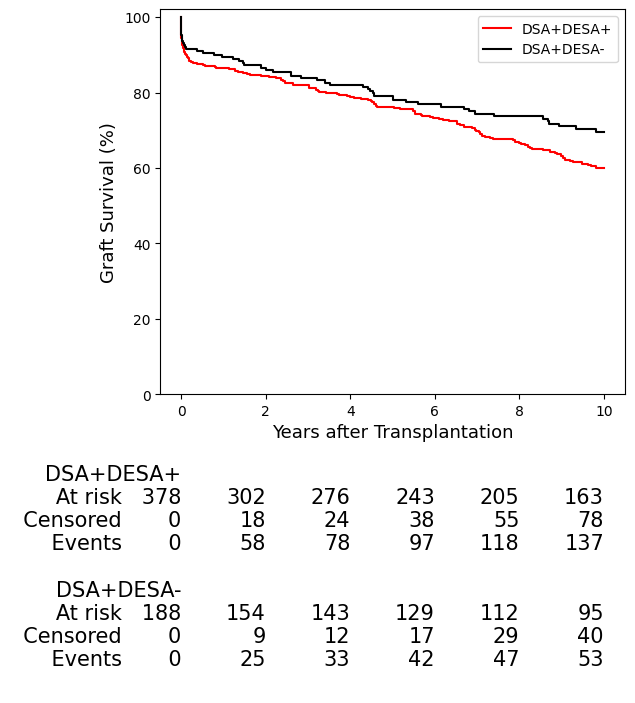

In [25]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines.plotting import add_at_risk_counts
import matplotlib.ticker as mtick
fontsize = 15
legend_size = 10

df_km = df.copy(deep=True)
df_km['T'] = df_km['GraftSurvival10Y_R']
df_km['E'] = df_km['FailureCode10Y_R'].astype(bool)

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(6, 5))

desa_pos = (df_km.DSA == 1) & (df.DESA_Status == 'DESA')
desa_neg = (df_km.DSA == 1) & (df.DESA_Status != 'DESA')

kmf1.fit(df_km[desa_pos]['T'], event_observed=df_km[desa_pos]['E'], label="DSA+DESA+")
kmf1.plot_survival_function(ax=ax, ci_show = False, color = 'red')

kmf2.fit(df_km[desa_neg]['T'], event_observed=df_km[desa_neg]['E'], label="DSA+DESA-")
kmf2.plot_survival_function(ax=ax, ci_show = False, color = 'black')

add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=fontsize, rows_to_show=["At risk", "Censored", "Events"])

#ax.yaxis.grid() # horizontal lines
#ax.xaxis.grid()
ax.set_xlabel("Years after Transplantation", fontsize=fontsize - 2);
ax.set_ylabel("Graft Survival (%)",  fontsize=fontsize - 2);
ax.legend(prop={"size":legend_size})
ax.set_ylim(0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 0, symbol = None))
#plt.show();
plt.savefig('dsa_v_desa.pdf', bbox_inches = 'tight')

## Q7
Count Tx'es that failed early (within 3 months and within 6 months)

In [26]:
print(f'''Number of transplants that failed within
3 months: {sum((df['FailureCode10Y_R'] == 1) & (df_km['GraftSurvival10Y_R'] <= .25))}
6 months: {sum((df['FailureCode10Y_R'] == 1) & (df_km['GraftSurvival10Y_R'] <= .5))}''')

Number of transplants that failed within
3 months: 292
6 months: 319
